In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [3]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 9), (3888, 7))

In [5]:
min = df_train[['Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Hour','DHI','DNI','WS','RH','T']].max()

In [6]:
for i, col in enumerate(['Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [7]:
Day  = df_train.iloc[:, :-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

In [8]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [9]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 7), (13116, 7), (39348, 2), (13116, 2))

In [11]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

In [12]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

In [13]:
epoch = 100

In [14]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 2s 2ms/step - loss: 370.4143 - val_loss: 175.5633
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 169.9044 - val_loss: 157.3284
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 152.4468 - val_loss: 149.5892
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 153.5761 - val_loss: 147.8619
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 147.7484 - val_loss: 147.8122
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 149.6038 - val_loss: 151.3657
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 149.6172 - val_loss: 147.0415
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 142.2509 - val_loss: 152.3711
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 149.2954 - val_loss: 147.6583
Epoch 10/100
615/615 [==============================] -

136.302001953125

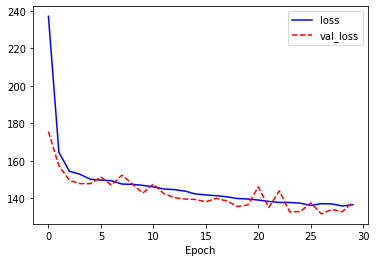

In [15]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [16]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 1.4483 - val_loss: 1.5774
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4007 - val_loss: 1.5916
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3897 - val_loss: 1.5876
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3827 - val_loss: 1.5768
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3955 - val_loss: 1.5852
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3861 - val_loss: 1.5943
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3928 - val_loss: 1.5911
Epoch 00007: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.2653 - val_loss: 2.5861
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2413 - val_loss: 2.5794
Epoch 3/100
820/820 [==============================] - 1s 1ms/s

820/820 [==============================] - 1s 1ms/step - loss: 2.7427 - val_loss: 3.1560
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 2.6503 - val_loss: 3.0179
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6172 - val_loss: 3.0192
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6241 - val_loss: 2.9968
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6248 - val_loss: 3.0859
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6254 - val_loss: 3.0436
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6226 - val_loss: 2.9981
Epoch 00006: early stopping
Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3403 - val_loss: 2.6802
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3168 - val_loss: 2.6758
Epoch 3/100
820/820 [==========================

Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3809 - val_loss: 1.5889
Epoch 00006: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 0.7780 - val_loss: 0.8960
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7671 - val_loss: 0.9577
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7748 - val_loss: 0.8861
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7689 - val_loss: 0.9138
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7690 - val_loss: 0.8798
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7647 - val_loss: 0.9059
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7790 - val_loss: 0.9289
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7827 - val_loss: 0.8960
Epoch 00008: early stopping


(3888, 18)

In [17]:
from lightgbm import LGBMRegressor

In [18]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.34889
Early stopping, best iteration is:
[418]	valid_0's quantile: 1.34812
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.14466
[1000]	valid_0's quantile: 2.13764
[1500]	valid_0's quantile: 2.13582
[2000]	valid_0's quantile: 2.1334
Early stopping, best iteration is:
[1749]	valid_0's quantile: 2.13312
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.53565
[1000]	valid_0's quantile: 2.50726
[1500]	valid_0's quantile: 2.49215
Early stopping, best iteration is:
[1604]	valid_0's quantile: 2.48959
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.66191
[1000]	valid_0's quantile: 2.62846
[1500]	valid_0's quantile: 2.61266
[2000]	valid_0's quantile: 2.6059
[2500]	valid_0's quantile: 2.59923
[3000]	valid_0's quantile: 2.59644
Early stopping, best iteration is:
[2707]	v

In [19]:
np.squeeze(np.array(df_test).reshape(3888, 7, 1))

array([[0.        , 0.        , 0.        , ..., 0.06666667, 0.79352884,
        0.3       ],
       [0.        , 0.        , 0.        , ..., 0.075     , 0.80012986,
        0.29814815],
       [0.04347826, 0.        , 0.        , ..., 0.08333333, 0.78259929,
        0.2962963 ],
       ...,
       [0.95652174, 0.        , 0.        , ..., 0.05833333, 0.63315658,
        0.58888889],
       [1.        , 0.        , 0.        , ..., 0.05      , 0.64982145,
        0.58148148],
       [1.        , 0.        , 0.        , ..., 0.05      , 0.66929986,
        0.57407407]])

In [20]:
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4352 - val_loss: 1.6001
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4210 - val_loss: 1.5990
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4133 - val_loss: 1.5978
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4169 - val_loss: 1.5973
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4245 - val_loss: 1.6026
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4155 - val_loss: 1.6114
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4168 - val_loss: 1.6229
Epoch 8/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4333 - val_loss: 1.5967
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4212 - val_loss: 1.5977
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4344 - va

820/820 [==============================] - 2s 2ms/step - loss: 2.2607 - val_loss: 2.6285
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 2.2568 - val_loss: 2.6953
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 2.2489 - val_loss: 2.6623
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 2.2628 - val_loss: 2.6477
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 2.2827 - val_loss: 2.5939
Epoch 7/100
820/820 [==============================] - 2s 3ms/step - loss: 2.2884 - val_loss: 2.5954
Epoch 8/100
820/820 [==============================] - 2s 3ms/step - loss: 2.3200 - val_loss: 2.6656
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 2.2611 - val_loss: 2.6261
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 2.3143 - val_loss: 2.5920
Epoch 11/100
820/820 [==============================] - 2s 2ms/step - loss: 2.2145 - val_loss: 2.6167


(3888, 9)

In [21]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day8).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4554 - val_loss: 1.6486
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4449 - val_loss: 1.6423
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4343 - val_loss: 1.6420
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4265 - val_loss: 1.6404
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4429 - val_loss: 1.6405
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4351 - val_loss: 1.6465
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4443 - val_loss: 1.6487
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4513 - val_loss: 1.6428
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4519 - val_loss: 1.6413
Epoch 00009: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 

820/820 [==============================] - 1s 2ms/step - loss: 2.3878 - val_loss: 2.7445
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 2.4258 - val_loss: 2.7309
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 2.4239 - val_loss: 2.7424
Epoch 9/100
820/820 [==============================] - 1s 2ms/step - loss: 2.3941 - val_loss: 2.7217
Epoch 10/100
820/820 [==============================] - 1s 2ms/step - loss: 2.4216 - val_loss: 2.7559
Epoch 11/100
820/820 [==============================] - 1s 2ms/step - loss: 2.3747 - val_loss: 2.7547
Epoch 12/100
820/820 [==============================] - 1s 2ms/step - loss: 2.4062 - val_loss: 2.7550
Epoch 13/100
820/820 [==============================] - 1s 2ms/step - loss: 2.4152 - val_loss: 2.7915
Epoch 14/100
820/820 [==============================] - 2s 2ms/step - loss: 2.4064 - val_loss: 2.7985
Epoch 00014: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 2s 2ms/step

(3888, 9)

In [23]:
model = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[39348, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 7), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 7)))

Epoch 1/100
615/615 [==============================] - 5s 4ms/step - loss: 666.8045 - val_loss: 380.4713
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 318.8514 - val_loss: 238.7859
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 212.8030 - val_loss: 182.7945
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: 176.5811 - val_loss: 158.7834
Epoch 5/100
615/615 [==============================] - 2s 3ms/step - loss: 153.1687 - val_loss: 147.4331
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: 147.3453 - val_loss: 147.4236
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: 144.8572 - val_loss: 138.9963
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: 136.7151 - val_loss: 138.6592
Epoch 9/100
615/615 [==============================] - 2s 3ms/step - loss: 141.1639 - val_loss: 138.1136
Epoch 10/100
615/615 [==============================] -

In [24]:
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5272 - val_loss: 1.6283
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4350 - val_loss: 1.6109
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4224 - val_loss: 1.6037
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4109 - val_loss: 1.5966
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4154 - val_loss: 1.5927
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4015 - val_loss: 1.6138
Epoch 7/100
820/820 [==============================] - 4s 4ms/step - loss: 1.4025 - val_loss: 1.5905
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4171 - val_loss: 1.5834
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3985 - val_loss: 1.5796
Epoch 10/100
820/820 [==============================] - 4s 4ms/step - loss: 1.4209 - va

820/820 [==============================] - 3s 3ms/step - loss: 2.1530 - val_loss: 2.5293
Epoch 12/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1544 - val_loss: 2.5233
Epoch 13/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1892 - val_loss: 2.5334
Epoch 14/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1902 - val_loss: 2.5285
Epoch 15/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1901 - val_loss: 2.5349
Epoch 16/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1890 - val_loss: 2.5320
Epoch 17/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1899 - val_loss: 2.5467
Epoch 00017: early stopping
0.3
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.6304 - val_loss: 2.9948
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6024 - val_loss: 2.9820
Epoch 3/100
820/820 [==============================] - 3s 3ms/ste

820/820 [==============================] - 6s 4ms/step - loss: 2.5979 - val_loss: 2.9435
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5539 - val_loss: 2.9159
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5444 - val_loss: 2.8993
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5341 - val_loss: 2.9269
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5539 - val_loss: 2.9283
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5640 - val_loss: 2.9316
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5776 - val_loss: 2.8921
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6072 - val_loss: 2.9129
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5360 - val_loss: 2.9328
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6005 - val_loss: 2.8813
E

820/820 [==============================] - 6s 4ms/step - loss: 1.3535 - val_loss: 1.5483
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3207 - val_loss: 1.5549
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3410 - val_loss: 1.5842
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3341 - val_loss: 1.5545
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3302 - val_loss: 1.6088
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3476 - val_loss: 1.5734
Epoch 00006: early stopping
0.9
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.7484 - val_loss: 0.8562
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7365 - val_loss: 0.8863
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.7453 - val_loss: 0.8834
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - lo

(3888, 9)

In [25]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5309 - val_loss: 1.6283
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4354 - val_loss: 1.6108
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4221 - val_loss: 1.6047
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4113 - val_loss: 1.5997
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4160 - val_loss: 1.5913
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4014 - val_loss: 1.6102
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4033 - val_loss: 1.5935
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4175 - val_loss: 1.5812
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3989 - val_loss: 1.5799
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4216 - va

820/820 [==============================] - 3s 3ms/step - loss: 2.1520 - val_loss: 2.5300
Epoch 12/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1540 - val_loss: 2.5274
Epoch 13/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1870 - val_loss: 2.5346
Epoch 14/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1901 - val_loss: 2.5247
Epoch 15/100
820/820 [==============================] - 3s 3ms/step - loss: 2.1895 - val_loss: 2.5307
Epoch 00015: early stopping
0.3
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.6350 - val_loss: 2.9904
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6003 - val_loss: 2.9811
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5953 - val_loss: 3.0044
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5686 - val_loss: 2.9780
Epoch 5/100
820/820 [==============================] - 3s 3ms/step 

820/820 [==============================] - 3s 3ms/step - loss: 2.6508 - val_loss: 3.0673
Epoch 00015: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 7s 5ms/step - loss: 2.5766 - val_loss: 2.9149
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5301 - val_loss: 2.9061
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5287 - val_loss: 2.9084
Epoch 4/100
820/820 [==============================] - 4s 5ms/step - loss: 2.5165 - val_loss: 2.9220
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5336 - val_loss: 2.9369
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5487 - val_loss: 2.9164
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5619 - val_loss: 2.8936
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5980 - val_loss: 2.9028
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - lo

820/820 [==============================] - 7s 5ms/step - loss: 1.3572 - val_loss: 1.5547
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3335 - val_loss: 1.5648
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3523 - val_loss: 1.5692
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3412 - val_loss: 1.5957
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3395 - val_loss: 1.5762
Epoch 6/100
820/820 [==============================] - 5s 6ms/step - loss: 1.3515 - val_loss: 1.5457
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3613 - val_loss: 1.5472
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3754 - val_loss: 1.5553
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3364 - val_loss: 1.5576
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3662 - val_loss: 1.5475
E

(3888, 9)

In [32]:
model = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[39348, 7]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 7), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 7)))

Epoch 1/100
615/615 [==============================] - 5s 4ms/step - loss: 724.6932 - val_loss: 455.4327
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 386.1254 - val_loss: 293.6385
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 258.7066 - val_loss: 217.2019
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: 205.7994 - val_loss: 180.0280
Epoch 5/100
615/615 [==============================] - 2s 3ms/step - loss: 170.1662 - val_loss: 160.1687
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: 156.8567 - val_loss: 152.5484
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: 149.9580 - val_loss: 143.3964
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: 139.4011 - val_loss: 141.0742
Epoch 9/100
615/615 [==============================] - 2s 3ms/step - loss: 142.6633 - val_loss: 138.9174
Epoch 10/100
615/615 [==============================] -

In [38]:
epoch = 100

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7.shape

0.1
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 1.5426 - val_loss: 1.6321
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4389 - val_loss: 1.6122
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4231 - val_loss: 1.6042
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4103 - val_loss: 1.6000
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4143 - val_loss: 1.5885
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3980 - val_loss: 1.6121
Epoch 7/100
820/820 [==============================] - 4s 4ms/step - loss: 1.4021 - val_loss: 1.5926
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4165 - val_loss: 1.5810
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3991 - val_loss: 1.5786
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4233 - va

0.4
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.7830 - val_loss: 3.1333
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7425 - val_loss: 3.1115
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7306 - val_loss: 3.1331
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7144 - val_loss: 3.1251
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7518 - val_loss: 3.1372
Epoch 00005: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 2.7004 - val_loss: 3.0079
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6506 - val_loss: 2.9908
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6364 - val_loss: 2.9909
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6337 - val_loss: 3.0122
Epoch 5/100
820/820 [==============================] - 

820/820 [==============================] - 9s 6ms/step - loss: 1.4988 - val_loss: 1.6595
Epoch 2/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4676 - val_loss: 1.6524
Epoch 3/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4739 - val_loss: 1.6671
Epoch 4/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4702 - val_loss: 1.6990
Epoch 5/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4860 - val_loss: 1.7439
Epoch 00005: early stopping
0.9
Epoch 1/100
820/820 [==============================] - 7s 4ms/step - loss: 0.8548 - val_loss: 0.9588
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.8289 - val_loss: 0.9577
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.8374 - val_loss: 0.9365
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8346 - val_loss: 0.9467
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - lo

(3888, 9)

In [39]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)

0.1
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 1.5498 - val_loss: 1.6322
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4397 - val_loss: 1.6133
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4235 - val_loss: 1.6054
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4101 - val_loss: 1.6023
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4144 - val_loss: 1.5887
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3977 - val_loss: 1.6123
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4010 - val_loss: 1.5937
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4159 - val_loss: 1.5835
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3975 - val_loss: 1.5787
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4217 - va

820/820 [==============================] - 7s 4ms/step - loss: 2.7806 - val_loss: 3.1320
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 2.7389 - val_loss: 3.1052
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 2.7272 - val_loss: 3.1268
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.7116 - val_loss: 3.1222
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 2.7484 - val_loss: 3.1452
Epoch 00005: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.6983 - val_loss: 3.0105
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6515 - val_loss: 2.9830
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6329 - val_loss: 2.9862
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6338 - val_loss: 3.0172
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - lo

Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4660 - val_loss: 1.6491
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4728 - val_loss: 1.6545
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4646 - val_loss: 1.7598
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4883 - val_loss: 1.7148
Epoch 00005: early stopping
0.9
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.8500 - val_loss: 0.9423
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.8271 - val_loss: 0.9480
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.8340 - val_loss: 0.9410
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.8317 - val_loss: 0.9486
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.8363 - val_loss: 0.9507
Epoch 6/100
820/820 [==============================] - 3s 4

In [40]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_1.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [41]:
res_0 = pd.DataFrame()
res_0res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [42]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [45]:
res_0[:48]#.to_csv('0.csv', index=False)

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/5

In [48]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
submission.to_csv('./submission/submission_20210121-2.csv', index=False)

In [ ]:
(30*12)*0.1